# Import des librairies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pylab
import re
import time
from datetime import date
import plotly

from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score,train_test_split,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score,fbeta_score,accuracy_score,roc_auc_score
from sklearn.metrics import precision_score,recall_score,make_scorer,plot_confusion_matrix
from sklearn.metrics import average_precision_score,precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc, roc_curve, roc_auc_score
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.model_selection import KFold, StratifiedKFold
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
import itertools

In [2]:
pd.set_option('display.max_row', 1001)
pd.set_option('display.max_column', 400)
# pd.set_option('display.column_space', 200)
# pd.set_option('display.width', 10000)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Functions

In [3]:
def nan_df_create(data):
    
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    
    Inputs:
        data: 
            DataFrame
    
    Returns:
        DataFrame of NaN percentages
    '''
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df


def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):
    
    '''
    Function to plot Bar Plots of NaN percentages for each Column with missing values
    
    Inputs:
        df_nan: 
            DataFrame of NaN percentages
        title_name: 
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot    
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
    '''
    
    #checking if there is any column with NaNs or not.
    if df_nan.percent.sum() != 0:
        print(f"Number of columns having NaN values: {df_nan[df_nan['percent'] != 0].shape[0]} columns")
        
        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'column', y = 'percent', data = df_nan[df_nan['percent'] > 0])
        plt.xticks(rotation = rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"The dataframe {title_name} does not contain any NaN values.")
        
        
def plot_stats(df, feature,title,label_rotation=False,horizontal_layout=True):
    labels = ['Remboursé', 'Non Remboursé']
    sns.countplot(x=feature, hue='TARGET', data=df, palette='Blues')
    plt.legend(labels = labels, frameon=True)
    plt.xticks(rotation = 90)
    plt.title(title)
    plt.show()

def remove_missing_columns(df, threshold):
    
    # Calculate missing stats for df
    df_miss = pd.DataFrame(df.isnull().sum())
    df_miss['percent'] = 100 * df_miss[0] / len(df)
    
    # list of missing columns for df
    missing_df_columns = list(df_miss.index[df_miss['percent'] > threshold])

    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_df_columns), threshold))
    
    # Drop the missing columns and return
    df = df.drop(columns = missing_df_columns)
    
    return df

def plot_confusion_matrix1(cm, classes,
                          normalize='all',
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    


 https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features/
 
 https://www.kaggle.com/code/atilaysamiloglu/home-credit-default-dsmlbc4-gr2

In [4]:
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(nan_as_category = False):
    # Read data and merge
    df = application_train
    test_df = application_test
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(nan_as_category = True):
    bureau_df = bureau
    bb = bureau_balance
    
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau_df, bureau_cat = one_hot_encoder(bureau_df, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau_df = bureau_df.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau_df.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau_df.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau_df[bureau_df['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau_df[bureau_df['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(nan_as_category = True):
    prev = previous_application
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(nan_as_category = True):
    pos = POS_CASH_balance
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

    return pos_agg

# Preprocess installments_payments.csv
def installments(nan_as_category = True):
    ins = installments_payments
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card(nan_as_category = True):
    cc = credit_card_balance
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

    return cc_agg

# Chargement des données

In [5]:
application_train = pd.read_csv("application_train.csv")
application_test = pd.read_csv("application_test.csv")
bureau = pd.read_csv("bureau.csv")
bureau_balance = pd.read_csv("bureau_balance.csv")
previous_application = pd.read_csv("previous_application.csv")
POS_CASH_balance = pd.read_csv("POS_CASH_balance.csv")
installments_payments = pd.read_csv("installments_payments.csv")
credit_card_balance = pd.read_csv("credit_card_balance.csv")
sample_submission = pd.read_csv("sample_submission.csv")
homecredit = pd.read_csv('HomeCredit_columns_description.csv')

# Description des données

In [6]:
datasets_dict = {"application_train": application_train, "application_test": application_test, 
                 "bureau": bureau, "bureau_balance": bureau_balance, 
                 "previous_application": previous_application,"POS_CASH_balance": POS_CASH_balance,
                 "installments_payments":installments_payments,"credit_card_balance": credit_card_balance, 
                 "sample_submission": sample_submission, "home_credit":homecredit }

In [7]:
for item in datasets_dict:
    print("**")
    print("Le jeu de données %s contient %d lignes et %d colonnes." % (item, datasets_dict[item].shape[0], datasets_dict[item].shape[1]))
    print(f"{datasets_dict[item].duplicated().sum()} doublons et {(datasets_dict[item].isna().sum().sum() / datasets_dict[item].shape[0]/datasets_dict[item].shape[1])*100} % Nans")

**
Le jeu de données application_train contient 307511 lignes et 122 colonnes.
0 doublons et 24.39594190712943 % Nans
**
Le jeu de données application_test contient 48744 lignes et 121 colonnes.
0 doublons et 23.81168676153234 % Nans
**
Le jeu de données bureau contient 1716428 lignes et 17 colonnes.
0 doublons et 13.502552290879322 % Nans
**
Le jeu de données bureau_balance contient 27299925 lignes et 3 colonnes.
0 doublons et 0.0 % Nans
**
Le jeu de données previous_application contient 1670214 lignes et 37 colonnes.
0 doublons et 17.97687747344498 % Nans
**
Le jeu de données POS_CASH_balance contient 10001358 lignes et 8 colonnes.
0 doublons et 0.06518864738168557 % Nans
**
Le jeu de données installments_payments contient 13605401 lignes et 8 colonnes.
0 doublons et 0.005337953655316738 % Nans
**
Le jeu de données credit_card_balance contient 3840312 lignes et 23 colonnes.
0 doublons et 6.654074392687479 % Nans
**
Le jeu de données sample_submission contient 48744 lignes et 2 colonn

In [8]:
for item in datasets_dict:
    print("###########################################################")
    print(item)
    print(datasets_dict[item].columns)

###########################################################
application_train
Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)
###########################################################
application_test
Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',

## Home Credit

In [9]:
homecredit

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


    Homecredit contient les descriptions des colonnes des différents fichiers de données.

## application_train et application_test

### application_train

Il s'agit de la table principale, avec TARGET. Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

In [10]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Number of columns having NaN values: 67 columns


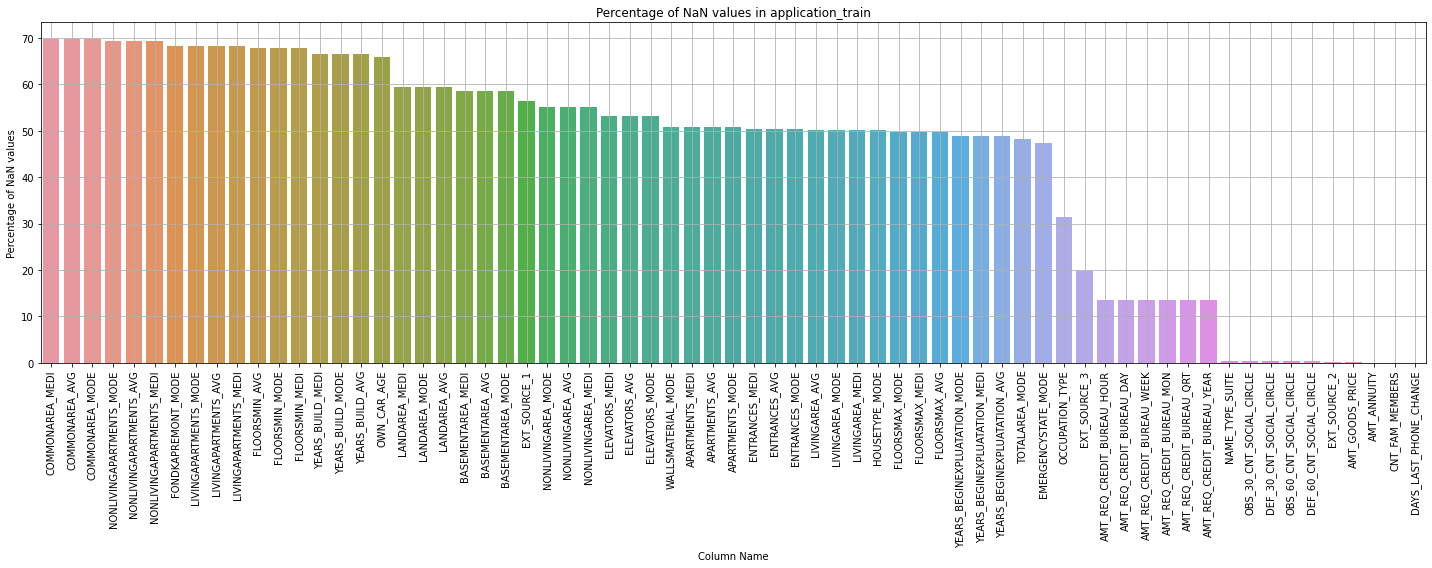

In [11]:
#### NaN Columns and Percentages
plot_nan_percent(nan_df_create(application_train), 'application_train', grid = True)

### application_test

Il s'agit de la table principale sans TARGET

In [12]:
application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

Number of columns having NaN values: 64 columns


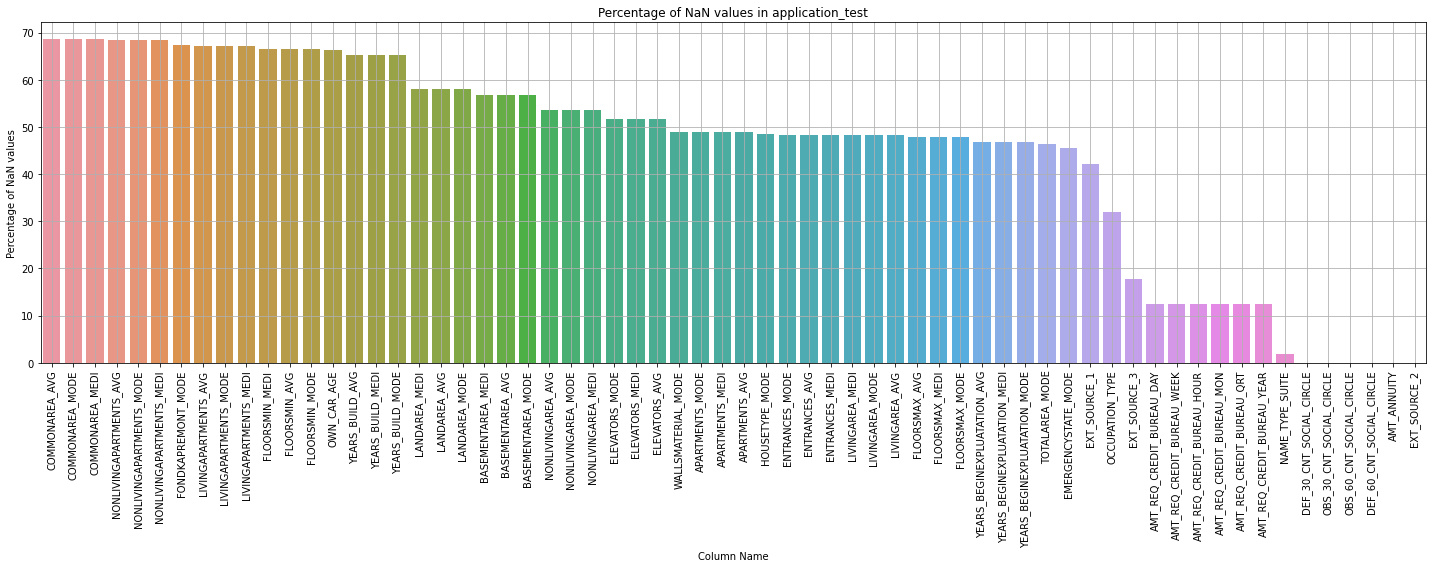

In [13]:
#### NaN Columns and Percentages
plot_nan_percent(nan_df_create(application_test), 'application_test', grid = True)

Le pourcentages de valeurs NaNs sont assez similaires à ceux présents dans l'ensemble de données Train. On peut en conclure que les ensembles train et de test ont une distribution à peu près similaire.


### Analyse exploratoire

**Répartition de la variable cible "TARGET" selon les deux classes**


- 0 : le crédit est remboursé
- 1 : le crédit est non remboursé

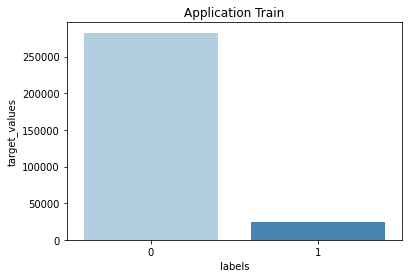

In [14]:
target = application_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': target.index,
                   'target_values': target.values
                  })
plt.title('Application Train')
sns.barplot(x = 'labels', y="target_values", data=df, palette='Blues')
plt.show()

On peut voir qu'il y a un déséquilibre des données.  Le jeu de données contient largement plus de crédit remboursé que non remboursé.

<AxesSubplot:>

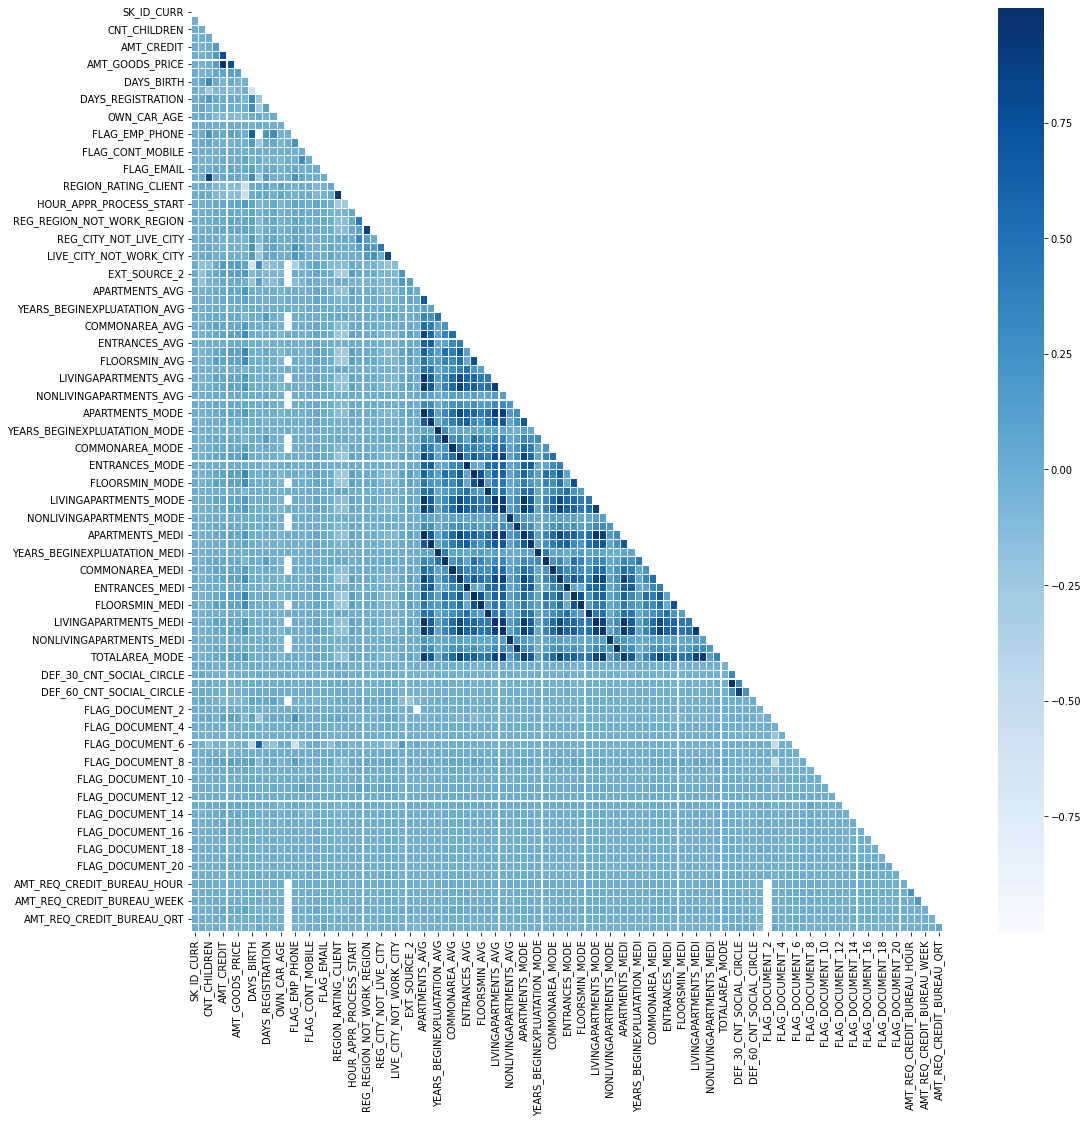

In [15]:
# Corrélations des variables numériques : Matrice de corrélation heatmap 
matrix=application_train.corr()
fig,axes=plt.subplots(figsize=(17,17))
mask_array = np.ones(matrix.shape)
mask_array = np.triu(mask_array)
sns.heatmap(matrix, annot = False, mask = mask_array, linewidth = 0.1, cmap = 'Blues')

**Distribution de NAME_CONTRACT_TYPE**

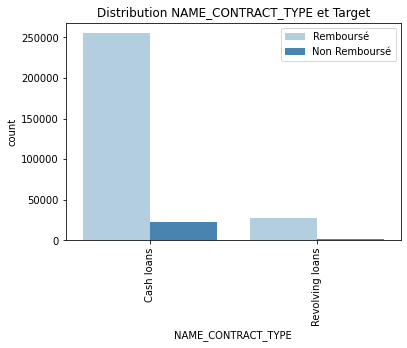

In [16]:
plot_stats(application_train,'NAME_CONTRACT_TYPE',"Distribution NAME_CONTRACT_TYPE et Target")

La plupart des prêts que les clients contractent sont en cash.

**Distribution des clients par genre**

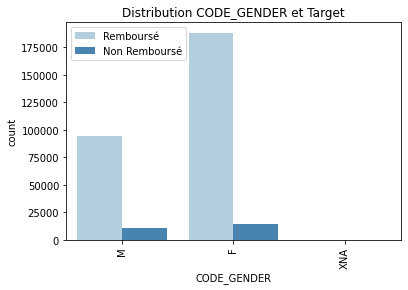

In [17]:
plot_stats(application_train,'CODE_GENDER',"Distribution CODE_GENDER et Target")

In [18]:
application_train.CODE_GENDER.value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

Il y a 4 lignes dans la table application_train qui ont des genres 'XNA' et peut donc être compté comme des valeurs NaN. 

    Il y a plus de clients féminins que de candidats masculins.

Parmi les clients, le type de profession le plus courant est celui d'ouvriers.
La deuxième profession la plus fréquente est le personnel de vente, suivi des gestionnaires.

**Distribution des clients par éducation**

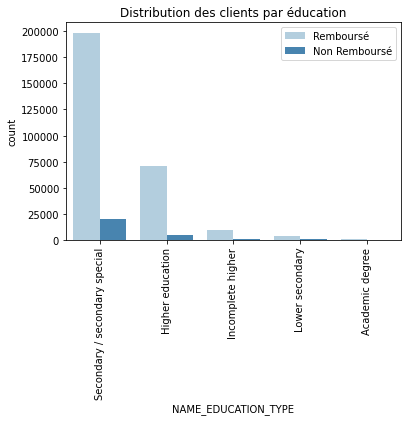

In [19]:
plot_stats(application_train,'NAME_EDUCATION_TYPE', 'Distribution des clients par éducation')

**Distribution des clients par âge**

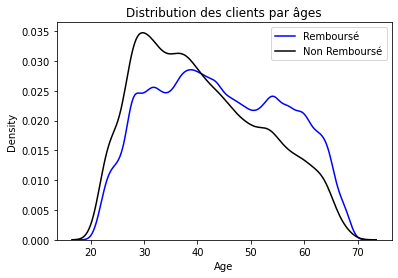

In [20]:
sns.kdeplot(application_train[application_train['TARGET'] == 0]['DAYS_BIRTH'] / -365, label = 'Remboursé', color='b')
sns.kdeplot(application_train[application_train['TARGET'] == 1]['DAYS_BIRTH'] / -365, label = 'Non Remboursé', color='black')
plt.legend()

plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution des clients par âges')
plt.show()

On peut observer que le pic d'âge des clients sont proches de 30 à 40 ans.

In [21]:
homecredit

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


## Suppression des colonnes inutile :


In [22]:
col_to_drop = ['DAYS_REGISTRATION', 'DAYS_ID_PUBLISH','FLAG_MOBIL', 'FLAG_EMP_PHONE', 'AMT_REQ_CREDIT_BUREAU_DAY',
               'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'AMT_REQ_CREDIT_BUREAU_MON',
               'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'AMT_REQ_CREDIT_BUREAU_QRT',
               'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
               'AMT_REQ_CREDIT_BUREAU_HOUR']
application_train = application_train.drop(col_to_drop, 1)
application_test = application_test.drop(col_to_drop, 1)

In [23]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,NaN,Laborers,1.0,2,2,WEDNESDAY,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,NaN,Core staff,2.0,1,1,MONDAY,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,26.0,Laborers,1.0,2,2,MONDAY,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,NaN,Laborers,2.0,2,2,WEDNESDAY,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## Valeurs aberrantes

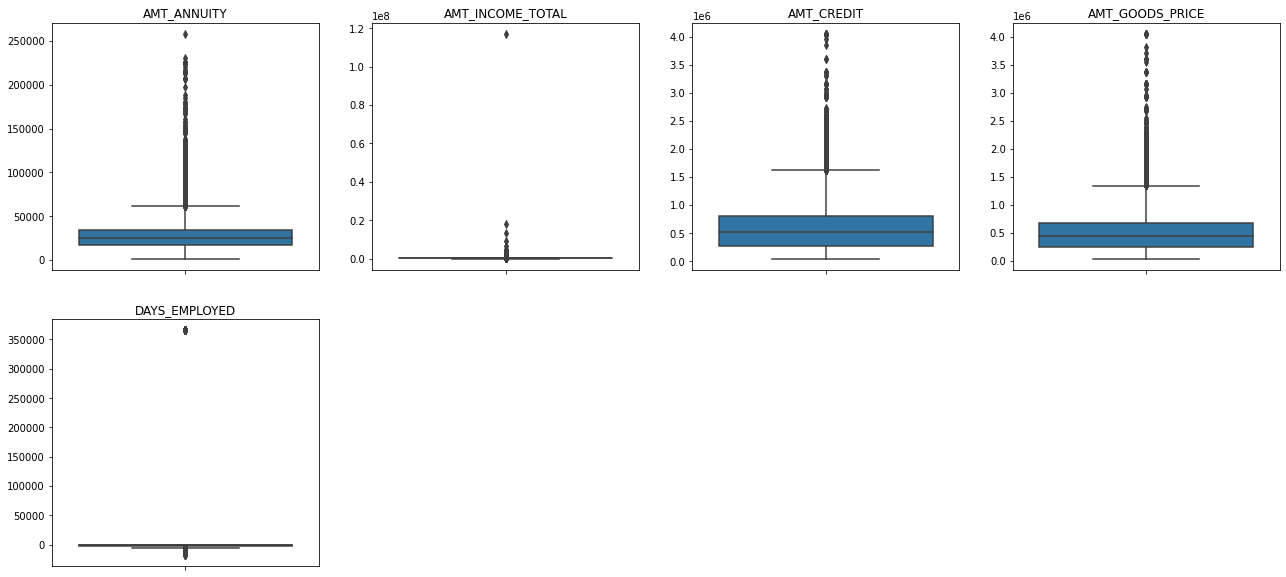

In [24]:
plt.figure(figsize=(22,10))

outlier = ['AMT_ANNUITY','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE','DAYS_EMPLOYED']
for i in enumerate(outlier):
    plt.subplot(2,4,i[0]+1)
    sns.boxplot(y=application_train[i[1]])
    plt.title(i[1])
    plt.ylabel("")

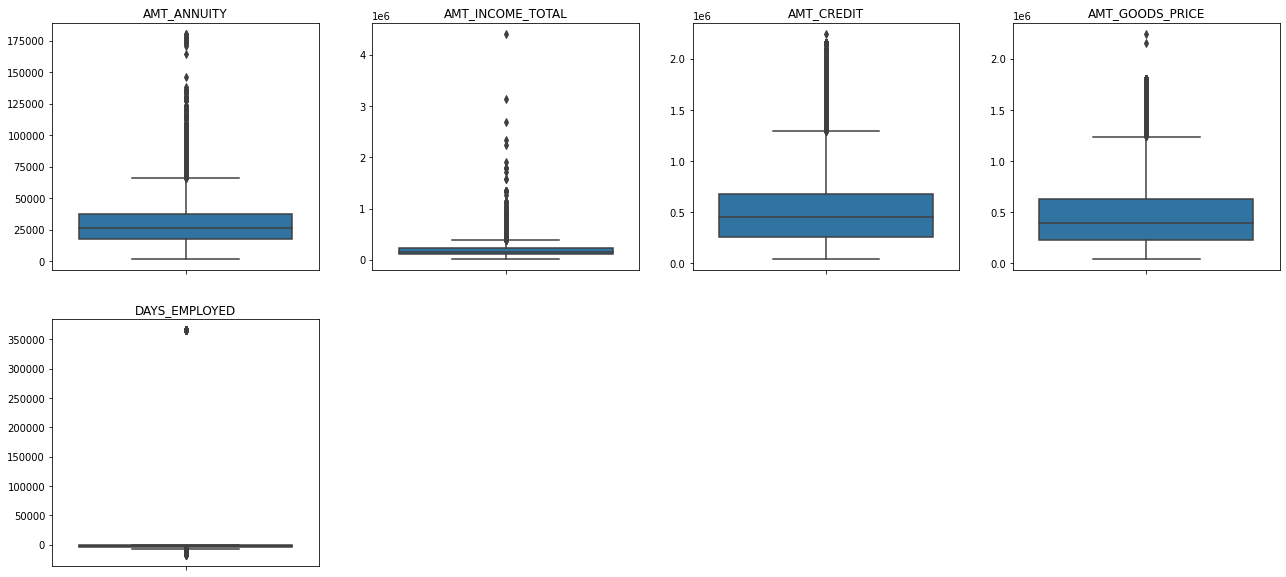

In [25]:
plt.figure(figsize=(22,10))

outlier = ['AMT_ANNUITY','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE','DAYS_EMPLOYED']
for i in enumerate(outlier):
    plt.subplot(2,4,i[0]+1)
    sns.boxplot(y=application_test[i[1]])
    plt.title(i[1])
    plt.ylabel("")

- AMT_INCOME_TOTAL a un grand nombre de valeurs aberrantes qui indiquent que quelques demandeurs de prêt ont un revenu élevé par rapport aux autres.

- DAYS_BIRTH n'a pas de valeurs aberrantes, ce qui signifie que les données disponibles sont fiables.

- DAYS_EMPLOYED a des valeurs aberrantes autour de 350000(jours), ce qui représente environ 958 ans, ce qui est impossible, donc c'est certainement une entrée incorrecte.

In [26]:
application_train = application_train[(application_train['DAYS_EMPLOYED'] <= 350000)]
application_test = application_test[(application_test['DAYS_EMPLOYED'] <= 350000)]

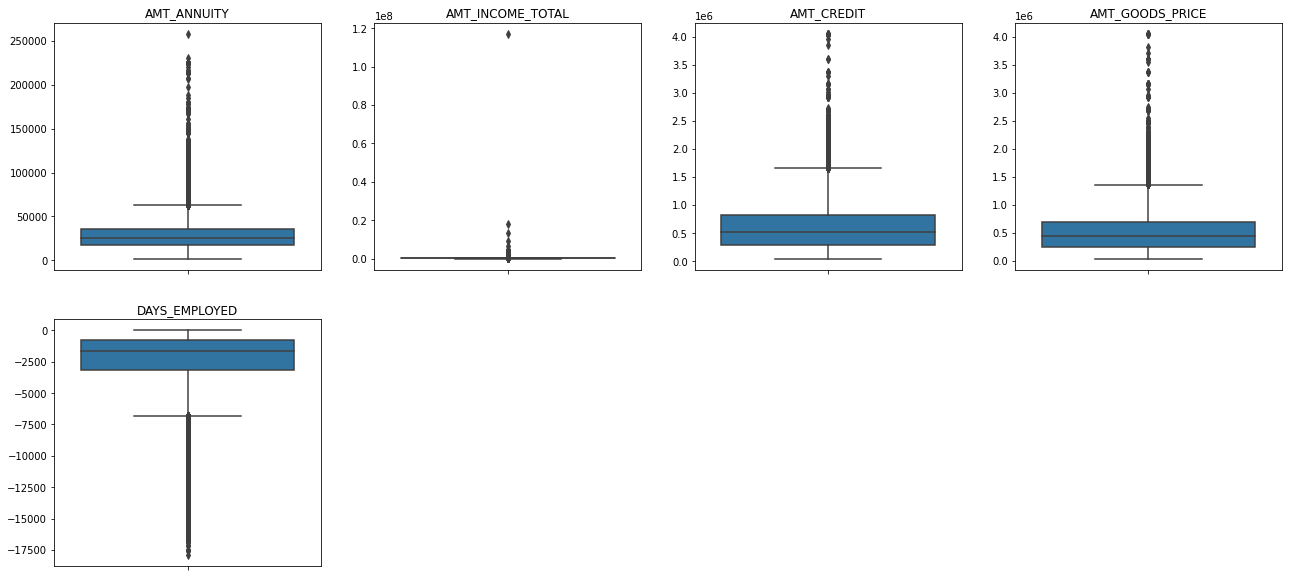

In [27]:
plt.figure(figsize=(22,10))

outlier = ['AMT_ANNUITY','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE','DAYS_EMPLOYED']
for i in enumerate(outlier):
    plt.subplot(2,4,i[0]+1)
    sns.boxplot(y=application_train[i[1]])
    plt.title(i[1])
    plt.ylabel("")

On supprime les lignes contenant des nans de moins de 20%

In [28]:
application_train = application_train.dropna(subset=['NAME_TYPE_SUITE', 'OBS_60_CNT_SOCIAL_CIRCLE','OCCUPATION_TYPE', 'EXT_SOURCE_2','AMT_ANNUITY'])

In [29]:
application_test = application_test.dropna(subset=['NAME_TYPE_SUITE', 'OBS_60_CNT_SOCIAL_CIRCLE','AMT_ANNUITY', 'EXT_SOURCE_2'])

On supprime les 4 lignes contenant XNA

In [30]:
application_train = application_train[(application_train['CODE_GENDER'] != "XNA")]

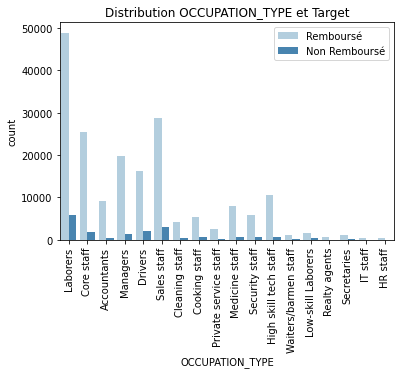

In [31]:
plot_stats(application_train,'OCCUPATION_TYPE','Distribution OCCUPATION_TYPE et Target')

In [32]:
# Suppression des colonnes de type *_MEDI , *_AVG
cols = [c for c in application_test.columns if c[-5:] != '_MEDI'  if c[-4:] != '_AVG']
application_test = application_test[cols]

In [33]:
# Suppression des colonnes de type *_MEDI , *_AVG 
cols = [c for c in application_train.columns if c[-5:] != '_MEDI'  if c[-4:] != '_AVG']
application_train = application_train[cols]

In [34]:
# Suppression des nans de moins de 20 %
application_train = application_train.dropna(subset=['AMT_REQ_CREDIT_BUREAU_WEEK', 'EXT_SOURCE_3'])

## Bureau

In [35]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [36]:
bureau.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


Number of columns having NaN values: 7 columns


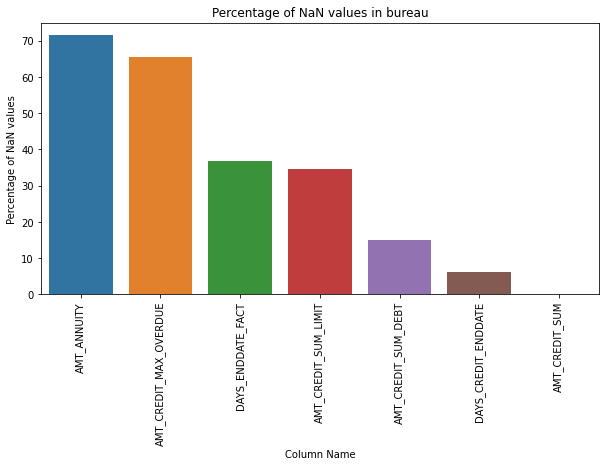

In [37]:
plot_nan_percent(nan_df_create(bureau), 'bureau', tight_layout = False, figsize = (10,5))

Sur 17 variables, 7 contiennent des valeurs NaN.
Les valeurs NaN les plus élevées sont observées avec la colonne AMT_ANNUITY qui a plus de 70% de valeurs manquantes. On peut supprimer les lignes contenant des nans de moins de 20%.

In [38]:
bureau = bureau.dropna(subset=['AMT_CREDIT_SUM', 'DAYS_CREDIT_ENDDATE','AMT_CREDIT_SUM_DEBT'])

### Merging the TARGETS from application_train to bureau table.

In [39]:
bureau_merged = application_train.iloc[:,:2].merge(bureau, on = 'SK_ID_CURR', how = 'left')

In [40]:
bureau_merged

,SK_ID_CURR,TARGET,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100002,1,6158906.0,Closed,currency 1,-1437.0,0.0,-1072.0,-1185.0,0.000,0.0,135000.0,0.00,0.0,0.0,Consumer credit,-1185.0,0.0
1,100002,1,6158908.0,Closed,currency 1,-645.0,0.0,85.0,-36.0,5043.645,0.0,120735.0,0.00,0.0,0.0,Consumer credit,-34.0,0.0
2,100002,1,6158903.0,Active,currency 1,-1042.0,0.0,780.0,NaN,NaN,0.0,450000.0,245781.00,0.0,0.0,Consumer credit,-7.0,0.0
3,100004,0,6829133.0,Closed,currency 1,-1326.0,0.0,-595.0,-683.0,NaN,0.0,94500.0,0.00,0.0,0.0,Consumer credit,-682.0,NaN
4,100004,0,6829134.0,Closed,currency 1,-408.0,0.0,-382.0,-382.0,0.000,0.0,94537.8,0.00,0.0,0.0,Consumer credit,-382.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784144,456255,0,5126330.0,Closed,currency 1,-1021.0,0.0,-959.0,-959.0,NaN,0.0,22995.0,0.00,NaN,0.0,Consumer credit,-953.0,3244.5
784145,456255,0,5126331.0,Active,currency 1,-1020.0,0.0,806.0,NaN,NaN,0.0,810000.0,595102.50,NaN,0.0,Consumer credit,-8.0,0.0
784146,456255,0,5126332.0,Active,currency 1,-378.0,0.0,27320.0,NaN,NaN,0.0,90000.0,61060.50,NaN,0.0,Credit card,-11.0,NaN
784147,456255,0,5126333.0,Active,currency 1,-363.0,0.0,1463.0,NaN,0.000,0.0,436032.0,363573.54,0.0,0.0,Consumer credit,-25.0,0.0


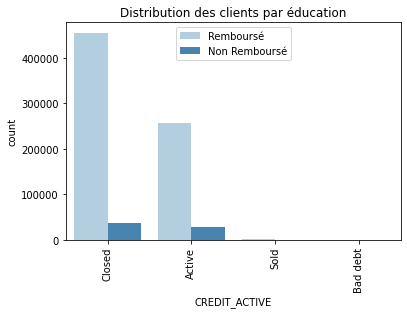

In [41]:
plot_stats(bureau_merged, 'CREDIT_ACTIVE', 'Distribution des clients par éducation')

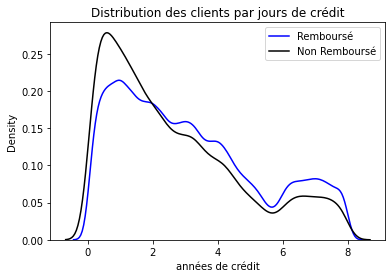

In [42]:
sns.kdeplot(bureau_merged[bureau_merged['TARGET'] == 0]['DAYS_CREDIT'] / -365, label = 'Remboursé', color='b')
sns.kdeplot(bureau_merged[bureau_merged['TARGET'] == 1]['DAYS_CREDIT'] / -365, label = 'Non Remboursé', color='black')
plt.legend()

plt.xlabel('années de crédit')
plt.ylabel('Density')
plt.title('Distribution des clients par jours de crédit')
plt.show()

Selon le graphique si le temps de prêts est moins, il y a plus tendence que c'est défaillant.

## bureau_balance

In [43]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [44]:
bureau_balance.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [45]:
plot_nan_percent(nan_df_create(bureau_balance), 'bureau_balance', tight_layout = False, figsize = (10,5))

The dataframe bureau_balance does not contain any NaN values.


<AxesSubplot:>

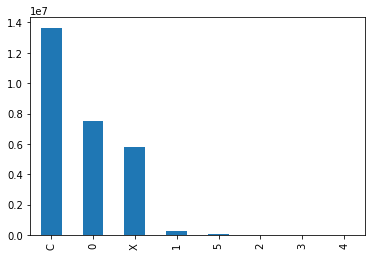

In [46]:
bureau_balance['STATUS'].value_counts().plot(kind='bar')

There are 8 unique values for the STATUS which are encoded. Each of them have a special meaning.

C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off.

## previous_application

In [47]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
previous_application.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

Number of columns having NaN values: 16 columns


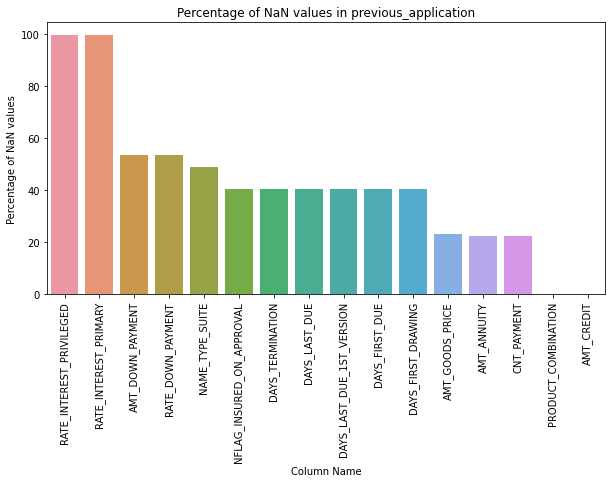

In [49]:
plot_nan_percent(nan_df_create(previous_application), 'previous_application', tight_layout = False, figsize = (10,5))

Sur 37 variables, 16 contiennent des valeurs NaN dont 2 de plus de 98%. On va donc supprimer les variables de plus de 98%

In [50]:
previous_application = remove_missing_columns(previous_application, 95)

There are 2 columns with greater than 95% missing values.


On supprime les lignes contenant des nans de moins de 20%.

In [51]:
previous_application = previous_application.dropna(subset=['AMT_CREDIT', 'PRODUCT_COMBINATION'])

## POS_CASH_balance

In [52]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [53]:
POS_CASH_balance.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


Number of columns having NaN values: 2 columns


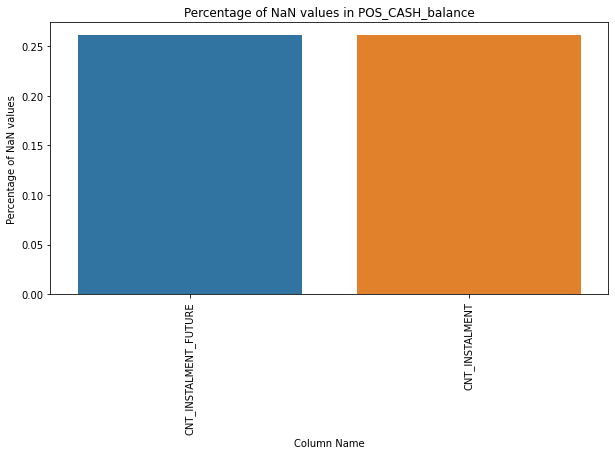

In [54]:
plot_nan_percent(nan_df_create(POS_CASH_balance), 'POS_CASH_balance', tight_layout = False, figsize = (10,5))

Sur 8 variables, 2 contiennent des valeurs NaN de moins de 1%. On peut donc les supprimer

In [55]:
# Reset index after drop
POS_CASH_balance=POS_CASH_balance.dropna().reset_index(drop=True)
POS_CASH_balance.shape

(9975174, 8)

## installments_payments

In [56]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [57]:
installments_payments.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


Number of columns having NaN values: 2 columns


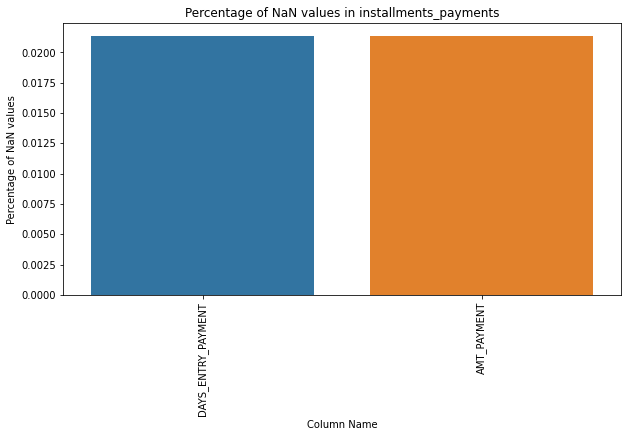

In [58]:
plot_nan_percent(nan_df_create(installments_payments), 'installments_payments', tight_layout = False, figsize = (10,5))

Sur 8 variables, 2 contiennent des valeurs NaN de moins de 1%.  On peut donc les supprimer

In [59]:
# Reset index after drop
installments_payments=installments_payments.dropna().reset_index(drop=True)

In [60]:
installments_payments.shape

(13602496, 8)

## credit_card_balance

In [61]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [62]:
credit_card_balance.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

Number of columns having NaN values: 9 columns


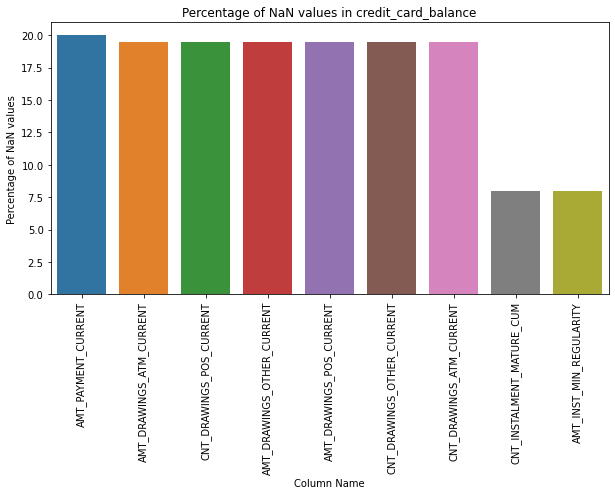

In [63]:
plot_nan_percent(nan_df_create(credit_card_balance), 'credit_card_balance', tight_layout = False, figsize = (10,5))

Sur 23 variables, 9 contiennent des valeurs NaN de moins de 20%. On peut les supprimer.

In [64]:
# Reset index after drop
credit_card_balance=credit_card_balance.dropna().reset_index(drop=True)

In [65]:
credit_card_balance.shape

(3014276, 23)

## sample_submission

In [66]:
sample_submission.head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


In [67]:
plot_nan_percent(nan_df_create(sample_submission), 'sample_submission', tight_layout = False, figsize = (10,5))

The dataframe sample_submission does not contain any NaN values.


In [68]:
sample_submission.TARGET.unique()

array([0.5])

    Le jeu de données sample_submission n'est pas utile pour la suite.

# Feaure Engineering

## Join tables

In [69]:
df_all = application_train_test()
df_all.shape

Train samples: 167730, test samples: 38725


(206455, 197)

In [70]:
bureau_df = bureau_and_balance()
print(bureau_df.shape)

(294722, 116)


In [71]:
df_all = df_all.join(bureau_df, how='left', on='SK_ID_CURR')
print(df_all.shape)

(206455, 313)


In [72]:
prev = previous_applications()
df_all = df_all.join(prev, how='left', on='SK_ID_CURR')

In [73]:
pos = pos_cash()
df_all = df_all.join(pos, how='left', on='SK_ID_CURR')

In [74]:
installments_p = installments()
df_all = df_all.join(installments_p, how='left', on='SK_ID_CURR')

In [75]:
cc = credit_card()
df_all = df_all.join(cc, how='left', on='SK_ID_CURR')

In [76]:
df_all.shape

(206455, 730)

In [77]:
df_clean = df_all

In [78]:
df_clean.drop(['index'], axis=1, inplace= True)

In [79]:
print("Le jeu de données df contient %d lignes et %d colonnes." % (df_clean.shape[0], df_clean.shape[1]))
print(f"{df_clean.duplicated().sum()} doublons et {(df_clean.isna().sum().sum() / df_clean.shape[0]/df_clean.shape[1])*100} % Nans")

Le jeu de données df contient 206455 lignes et 729 colonnes.
0 doublons et 23.49692813949665 % Nans


In [80]:
df_clean.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Rea

In [81]:
remove_missing_columns(df_clean, 75)

There are 133 columns with greater than 75% missing values.


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Rea

Renommage des variables

In [82]:
df_clean = df_clean.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Separation train and test data

In [83]:
col_drop = ['TARGET']
X = df_clean[df_clean['TARGET'].notnull()].drop(col_drop, axis=1)
y = df_clean[df_clean['TARGET'].notnull()]['TARGET']

In [84]:
X.shape

(167730, 728)

In [85]:
y.shape

(167730,)

Séparation train(70 %) et test(30 %) des données


In [86]:
X = X.set_index('SK_ID_CURR')

In [87]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Preprocessing

### Imputation des valeurs manquantes

In [88]:
# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)

In [89]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True) 
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [90]:
# Fit on the training data
imputer.fit(X_train)

SimpleImputer(strategy='median', verbose=0)

In [91]:
# Transform training data
X_train_preproc = imputer.transform(X_train)
X_test_preproc = imputer.transform(X_test)

### Scale

In [92]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))
# Repeat with the scaler
scaler.fit(X_train_preproc)
X_train_preproc = scaler.transform(X_train_preproc)
X_test_preproc = scaler.transform(X_test_preproc)
X_train = pd.DataFrame(scaler.transform(X_train_preproc), 
                      index=X_train.index, 
                      columns=X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test_preproc), 
                     index=X_test.index, 
                     columns=X_test.columns)

In [93]:
X_train

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,ORGANIZATION_TYPE_Industrytype13,ORGANIZATION_TYPE_Industrytype2,ORGANIZATION_TYPE_Industrytype3,ORGANIZATION_TYPE_Industrytype4,ORGANIZATION_TYPE_Industrytype5,ORGANIZATION_TYPE_Industrytype6,ORGANIZATION_TYPE_Industrytype7,ORGANIZATION_TYPE_Industrytype8,ORGANIZATION_TYPE_Industrytype9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_LegalServices,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGA

# Modélisation

On va mettre en place une comparaison d'algorithmes de classification, déterminer celui qui sera le plus adapté à la problématique (en prenant en compte le fait qu'il y ait un déséquilibre de TARGET, Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés.) tout en montrant l'importance des features puis séléctionner les features pertinentes pour les visualisations sur notre dashboard.

## Classifiers

In [94]:
classifiers = {
    "LogisticRegression": LogisticRegression(solver = 'lbfgs', max_iter=1000),
    "LGBMClassifier": LGBMClassifier(objective='binary', random_state=42),
    "XGBClassifier": XGBClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),    
    "RandomForestClassifier": RandomForestClassifier(random_state = 42, class_weight="balanced"),
    "AdaBoostClassifier": AdaBoostClassifier()
}

**Métriques**

Les algorithmes sont comparés par les métriques suivantes :

Accuracy_score : le ratio entre le nombre total de prédictions correctes et le nombre total de prédictions (c'est la justesse de la prédiction).

Precision : Le ratio entre les vrais positifs et tous les positifs

Recall : La moyenne harmonique de Precision et du Recall. Un bon score F1 indique une bonne Precision et une bonne valeur de Recall

F1_score : Ce coefficient est une moyenne de la précision et du rappel, il est calculé à partir de la précision et du rappel du test, où la précision est le nombre de vrais résultats positifs divisé par le nombre de tous les résultats positifs, y compris ceux qui ne sont pas identifiés correctement, et le rappel est le nombre de vrais résultats positifs divisé par le nombre de tous les échantillons qui auraient dû être identifiés comme positifs. La précision est également connue sous le nom de valeur prédictive positive et le rappel est également connu sous le nom de sensibilité dans la classification binaire diagnostique.

AUC : Aire sous la courbe ROC est la mesure de la capacité d'un classifieur à distinguer les classes. Plus l'AUC est élevée, plus la performance du modèle à distinguer les classes positives et négatives est bonne.
Matrice de confusion"

F-beta score: Le F-beta score applique des pondérations supplémentaires, valorisant l'une de la précision ou du rappel plus que l'autre. Plus le beta est petit, plus on valorise la précision, plus le beta est grand, plus on valorise le recall.

TP (True Positives) : les cas où la prédiction est positive, et où la valeur réelle est effectivement positive. 

TN (True Negatives) : les cas où la prédiction est négative, et où la valeur réelle est effectivement négative. 

FP (False Positive) : les cas où la prédiction est positive, mais où la valeur réelle est négative. 

FN (False Negative) : les cas où la prédiction est négative, mais où la valeur réelle est positive. 

In [95]:
y_train.value_counts(normalize=True)

0.0    0.915545
1.0    0.084455
Name: TARGET, dtype: float64

### Dummy Classifier

Text(0.5, 1.0, 'Dummy Classifier on Train')

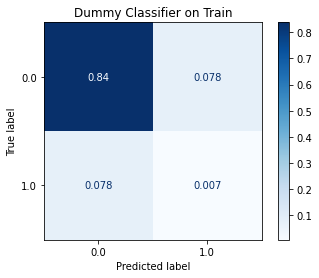

In [96]:
clf_dc = DummyClassifier(strategy='stratified')
clf_dc.fit(X_train, y_train)
y_pred = clf_dc.predict(X_train)
cm = plot_confusion_matrix(estimator=clf_dc, X=X_train, y_true=y_pred,
                      normalize='all', cmap='Blues')
plt.grid(False)

cm.ax_.set_title("Dummy Classifier on Train")

Text(0.5, 1.0, 'Dummy Classifier on Test')

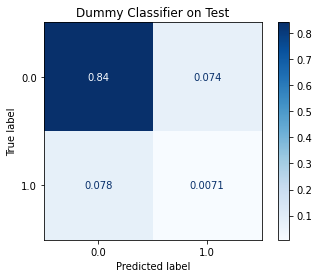

In [97]:
clf_dc = DummyClassifier(strategy='stratified')
clf_dc.fit(X_train, y_train)
y_pred = clf_dc.predict(X_test)
cm = plot_confusion_matrix(estimator=clf_dc, X=X_test, y_true=y_pred,
                      normalize='all', cmap='Blues')
plt.grid(False)

cm.ax_.set_title("Dummy Classifier on Test")

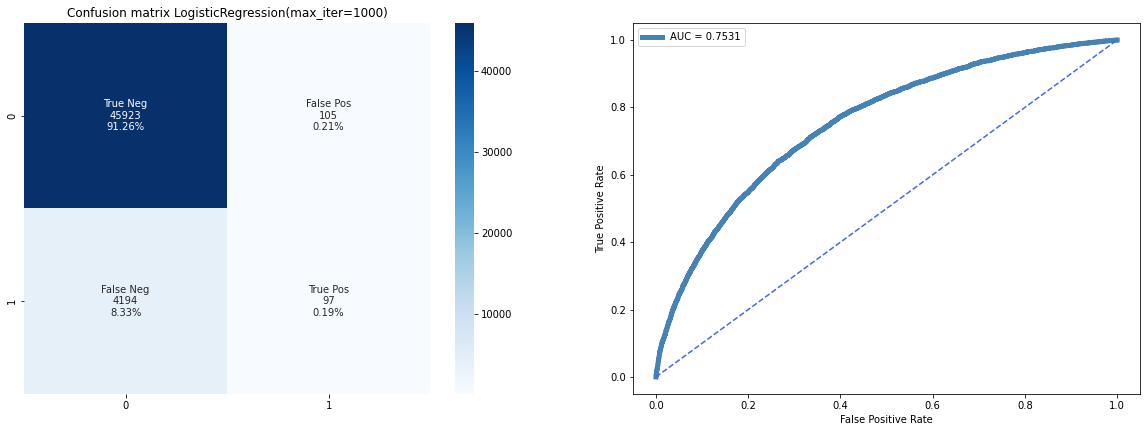

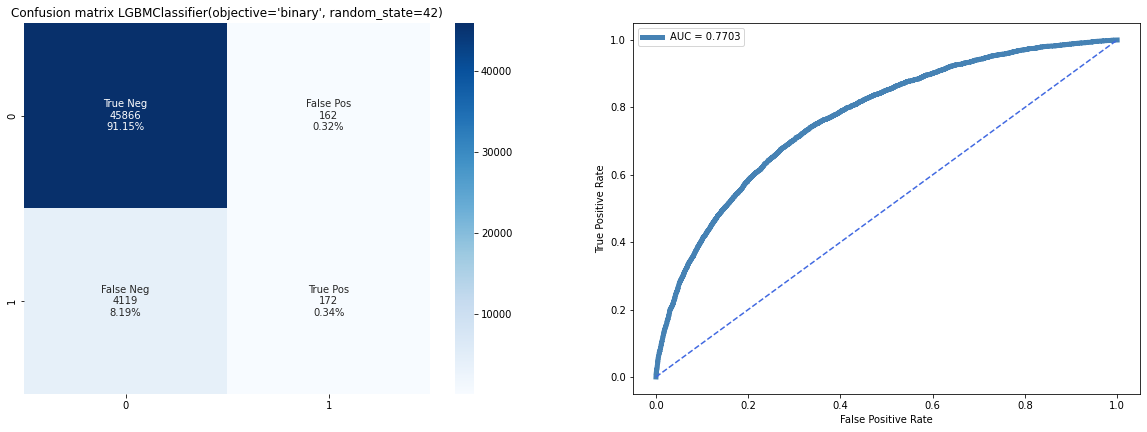

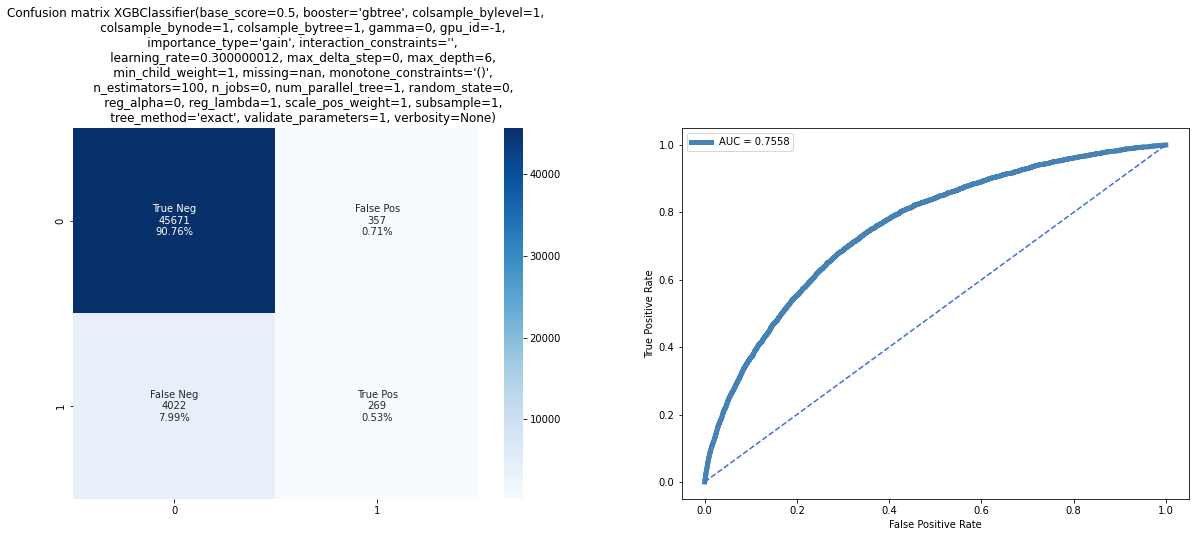

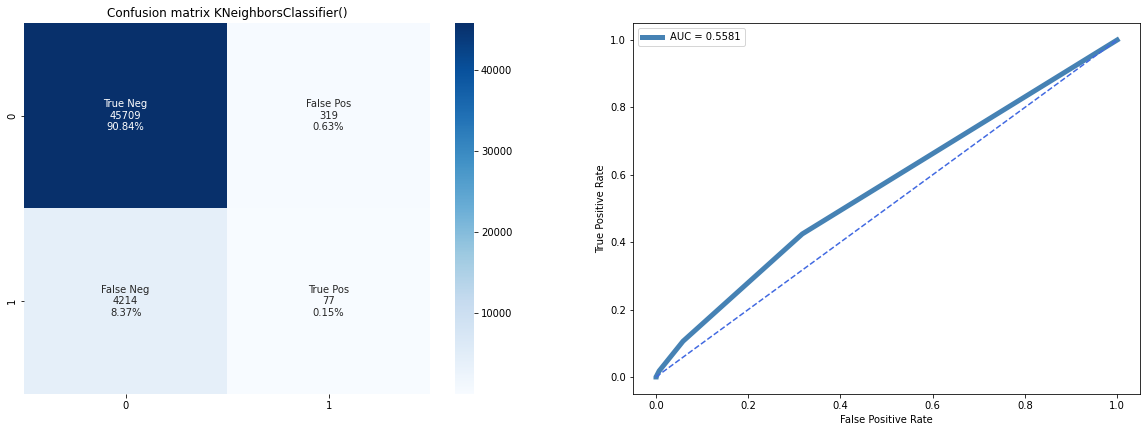

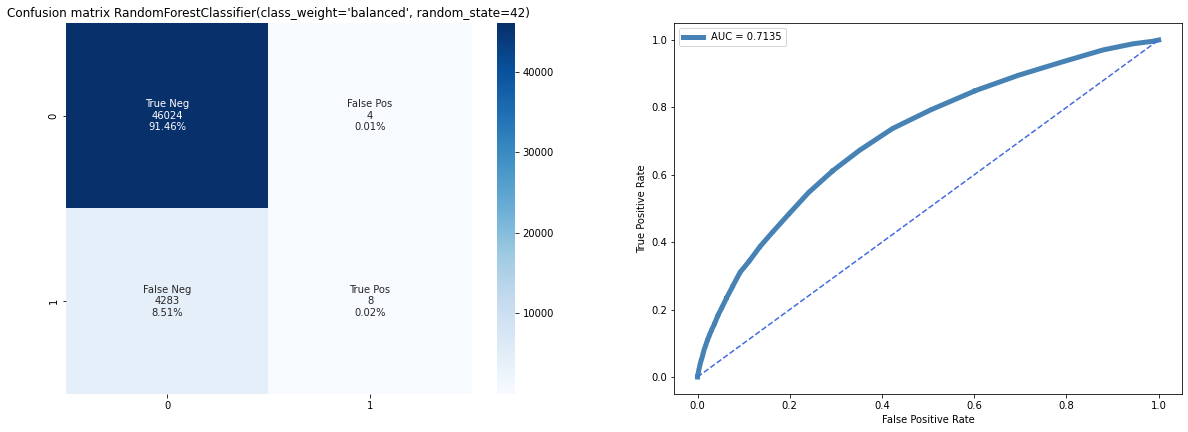

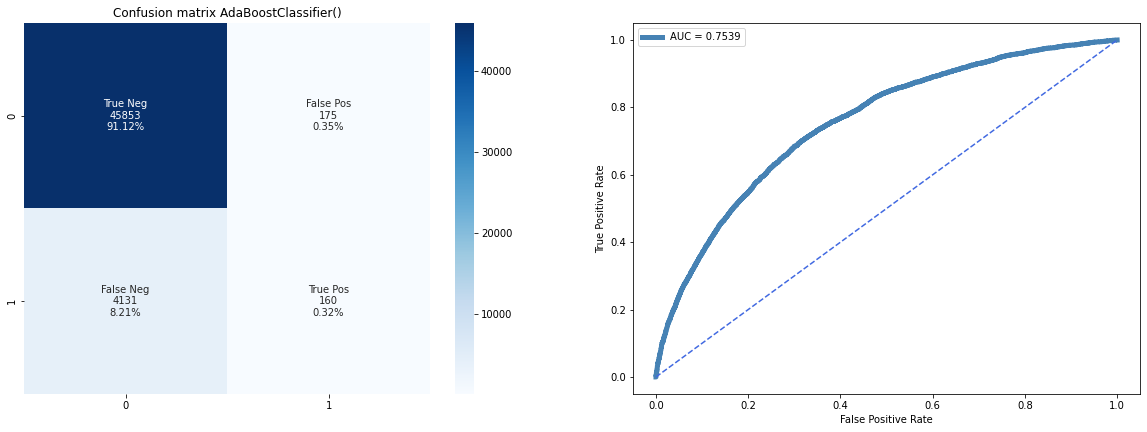

In [98]:
df_models = pd.DataFrame(columns=['model', 'run_time', 'Score test', 'Score train', 'accuracy', 'precision', 'recall', 'f1_score', 'roc auc score', 'fpr', 'tpr','fbeta'])

for key in classifiers:

    start_time = time.time()
    classifier = classifiers[key]
    model = classifier.fit(X_train, y_train)

    y_pred = model.predict(X_test) 
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    fig = plt.figure(figsize=(20,15))
    
    plt.subplot(221)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cnf_matrix.flatten()/np.sum(cnf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cnf_matrix, annot=labels, fmt="", cmap='Blues')
    
    plt.title(f'Confusion matrix {model}')
    

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, color='steelblue', linewidth=5, label='AUC = %0.4f' %roc_auc_score(y_test, y_pred_proba))
    plt.plot([0, 1], [0, 1], color='royalblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.show()
            
    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'Score test': model.score(X_test,y_test),
           'Score train': model.score(X_train,y_train),
           'accuracy': accuracy_score(y_test, y_pred),
           'precision': precision_score(y_test, y_pred, average='binary'),
           'recall': recall_score(y_test, y_pred, average='binary'),
           'f1_score': f1_score(y_test, y_pred, average='binary'),
           'roc auc score': roc_auc_score(y_test, y_pred_proba),
           'fpr':fpr,
           'tpr':tpr,
           'fbeta': fbeta_score(y_test,model.predict(X_test),beta=10)
    }
    
    df_models = df_models.append(row, ignore_index=True)

In [99]:
df_models

,model,run_time,Score test,Score train,accuracy,precision,recall,f1_score,roc auc score,fpr,tpr,fbeta
0,LogisticRegression,1.59,0.914565,0.915979,0.914565,0.480198,0.022605,0.043178,0.753066,"[0.0, 0.0, 4.345181194055792e-05, 4.3451811940...","[0.0, 0.00023304591004427873, 0.00023304591004...",0.022821
1,LGBMClassifier,0.4,0.914923,0.921268,0.914923,0.514970,0.040084,0.074378,0.770327,"[0.0, 0.0, 0.0, 2.172590597027896e-05, 2.17259...","[0.0, 0.00023304591004427873, 0.00069913773013...",0.040453
2,XGBClassifier,4.26,0.912975,0.936233,0.912975,0.429712,0.062689,0.109416,0.755770,"[0.0, 0.0, 2.172590597027896e-05, 2.1725905970...","[0.0, 0.00023304591004427873, 0.00023304591004...",0.063224
3,KNeighborsClassifier,6.02,0.909915,0.919488,0.909915,0.194444,0.017945,0.032857,0.558107,"[0.0, 0.0, 0.0005865994611975319, 0.0069305640...","[0.0, 0.00023304591004427873, 0.00116522955022...",0.018107
4,RandomForestClassifier,1.9,0.914804,0.999966,0.914804,0.666667,0.001864,0.003718,0.713488,"[0.0, 0.0, 4.345181194055792e-05, 6.5177717910...","[0.0, 0.00023304591004427873, 0.00023304591004...",0.001883
5,AdaBoostClassifier,2.61,0.914426,0.915493,0.914426,0.477612,0.037287,0.069174,0.753927,"[0.0, 2.172590597027896e-05, 4.345181194055792...","[0.0, 0.0, 0.0, 0.0013982754602656724, 0.00139...",0.037631


On peut constater que l'accuracy du modèle est excellente, mais cela est dû au fait que le jeu de données est fortement déséquilibré. Les classifiers semble classer la majeure partie des données comme remboursé

### Score ROC AUC

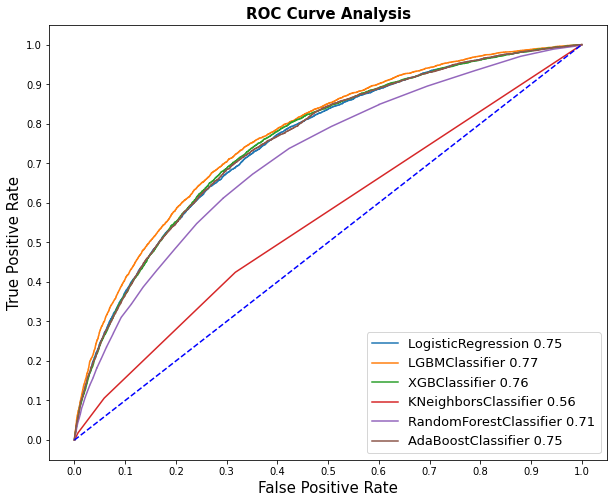

In [100]:
fig = plt.figure(figsize=(10,8))

for i in df_models.index:
    plt.plot(df_models.loc[i]['fpr'], 
             df_models.loc[i]['tpr'], 
             label=df_models.loc[i]['model']+ f" {df_models.loc[i]['roc auc score']:.2f}"
             )
    
plt.plot([0,1], [0,1], color='blue', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

## Resampling

### Over Sampling

SMOTE to create synthetic samples similar to the actual data to equalize our classes.

In [101]:
over_sm = SMOTE(sampling_strategy=0.85)
X_train_over_sm, y_train_over_sm = over_sm.fit_resample(X_train, y_train)
y_train_over_sm.value_counts(normalize=True)

0.0    0.540543
1.0    0.459457
Name: TARGET, dtype: float64

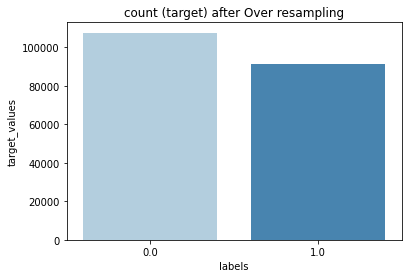

In [102]:
target = y_train_over_sm.value_counts()
df = pd.DataFrame({'labels': target.index,
                   'target_values': target.values
                  })
plt.title('count (target) after Over resampling')
sns.barplot(x = 'labels', y="target_values", data=df, palette='Blues')
plt.show()

#### Dummy Classifier

Updating the Dummy

Text(0.5, 1.0, 'Dummy Classifier on train with Over sampling applied')

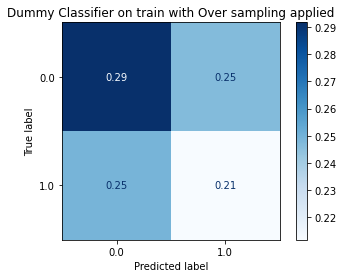

In [103]:
#updating Dummy Classifier with SMOTE’d data
clf_over_sm = DummyClassifier(strategy='stratified')
clf_over_sm.fit(X_train_over_sm, y_train_over_sm)
y_pred = clf_over_sm.predict(X_train_over_sm)

cm = plot_confusion_matrix(estimator=clf_over_sm, X=X_train_over_sm, y_true=y_pred,
                      normalize='all', cmap='Blues')
plt.grid(False)

cm.ax_.set_title("Dummy Classifier on train with Over sampling applied")


Text(0.5, 1.0, 'Dummy Classifier on test with Over sampling applied')

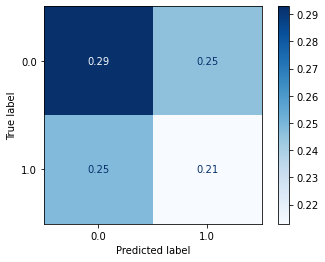

In [104]:
#updating Dummy Classifier with SMOTE’d data
clf_over_sm = DummyClassifier(strategy='stratified')
clf_over_sm.fit(X_train_over_sm, y_train_over_sm)
y_pred = clf_over_sm.predict(X_test)
plot_confusion_matrix(estimator=clf_over_sm, X=X_test, y_true=y_pred,
                      normalize='all', cmap='Blues')
plt.grid(False)

cm.ax_.set_title("Dummy Classifier on test with Over sampling applied")

### Under Sampling

In [105]:
from imblearn.under_sampling import RandomUnderSampler

under_sm = RandomUnderSampler(sampling_strategy=0.75)

In [106]:
X_train_under_sm, y_train_under_sm = under_sm.fit_resample(X_train, y_train)
y_train_under_sm.value_counts(normalize=True)

0.0    0.571422
1.0    0.428578
Name: TARGET, dtype: float64

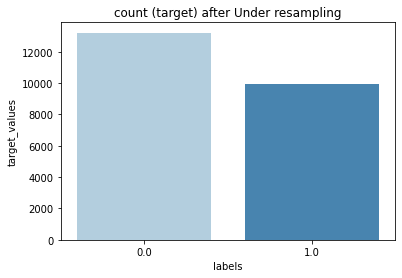

In [107]:
target = y_train_under_sm.value_counts()
df = pd.DataFrame({'labels': target.index,
                   'target_values': target.values
                  })
plt.title('count (target) after Under resampling')
sns.barplot(x = 'labels', y="target_values", data=df, palette='Blues')
plt.show()

#### Dummy Classifier

Text(0.5, 1.0, 'Dummy Classifier on train with Under sampling applied')

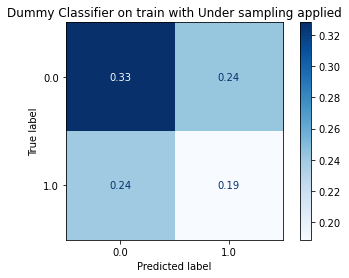

In [108]:
#updating Dummy Classifier with SMOTE’d data
clf_under_sm = DummyClassifier(strategy='stratified')
clf_under_sm.fit(X_train_under_sm, y_train_under_sm)
y_pred = clf_under_sm.predict(X_train_under_sm)
cm = plot_confusion_matrix(estimator=clf_under_sm, X=X_train_under_sm, y_true=y_pred,
                      normalize='all', cmap='Blues')
plt.grid(False)

cm.ax_.set_title("Dummy Classifier on train with Under sampling applied")

Text(0.5, 1.0, 'Dummy Classifier on Test with Under sampling applied')

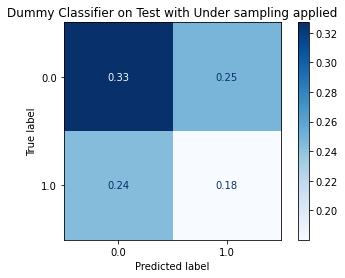

In [109]:
#updating Dummy Classifier with SMOTE’d data
clf_under_sm = DummyClassifier(strategy='stratified')
clf_under_sm.fit(X_train_under_sm, y_train_under_sm)
y_pred = clf_under_sm.predict(X_test)
cm = plot_confusion_matrix(estimator=clf_under_sm, X=X_test, y_true=y_pred,
                      normalize='all', cmap='Blues')
plt.grid(False)

cm.ax_.set_title("Dummy Classifier on Test with Under sampling applied")

On choisit le Over Sampling pour tester les différentes algorithmes

## Classifiers Over sampled

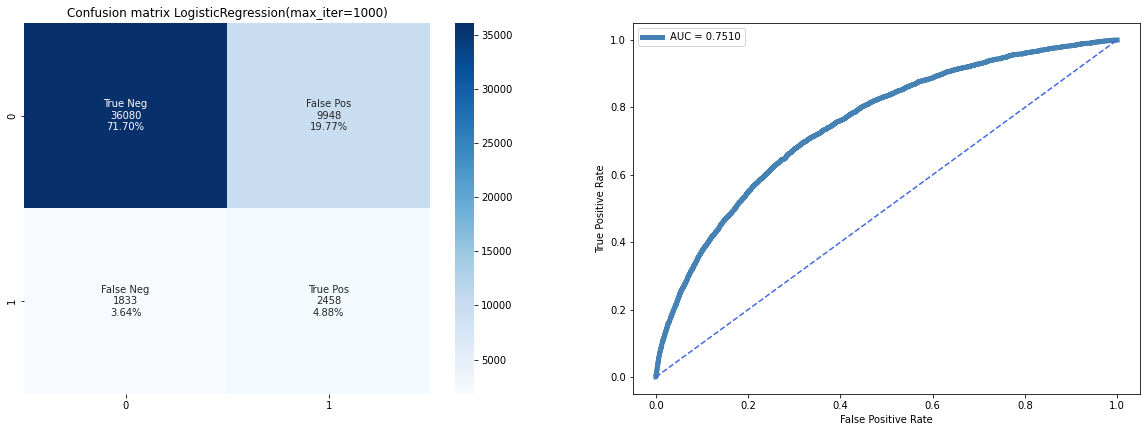

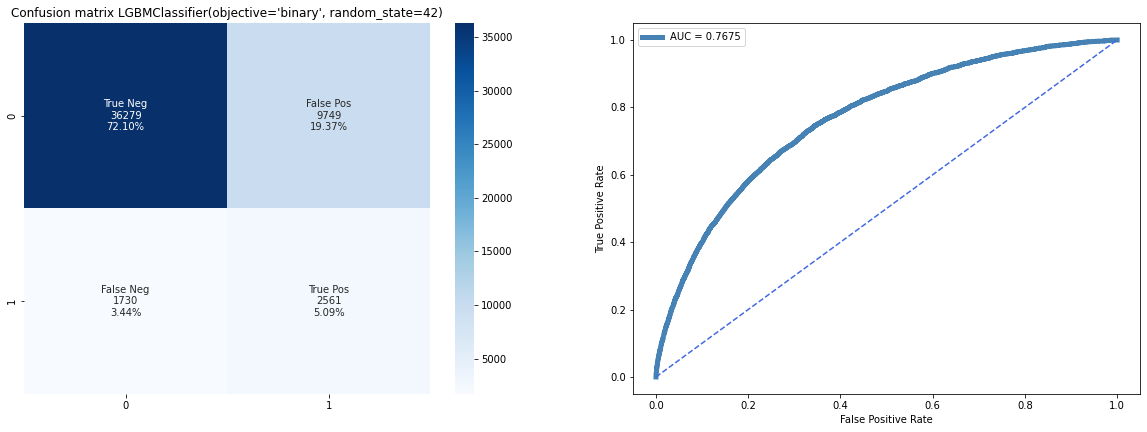

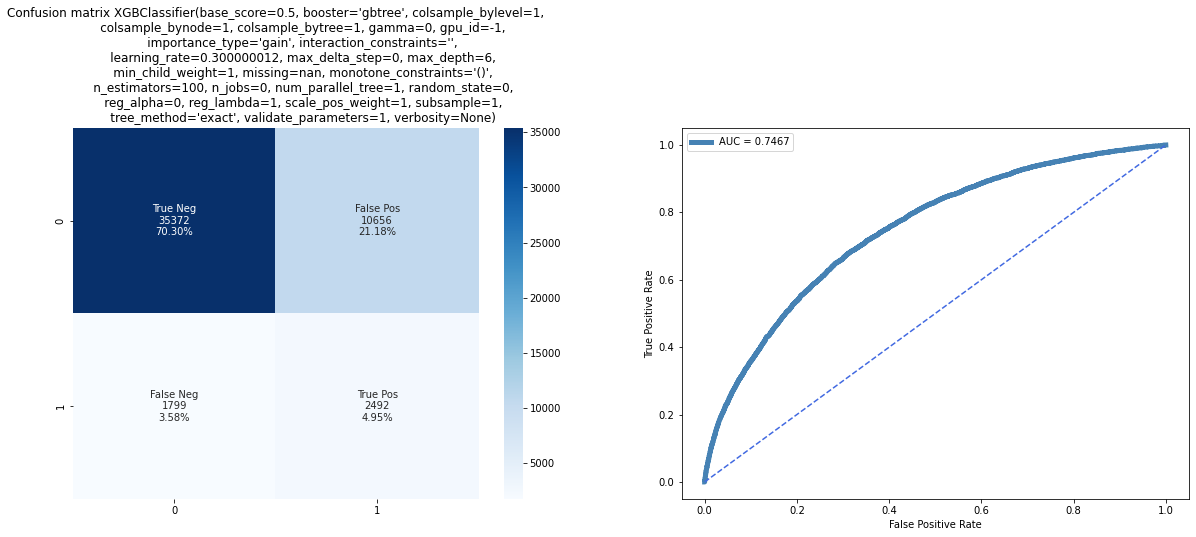

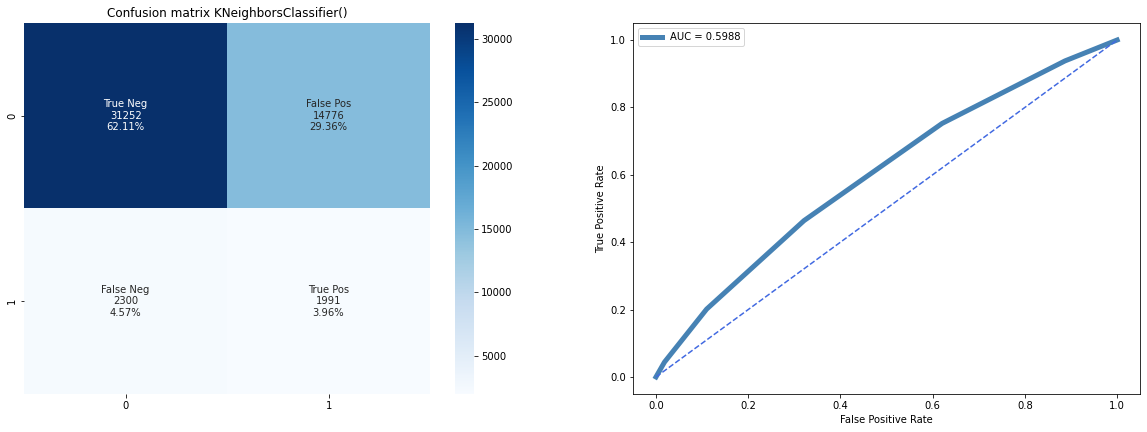

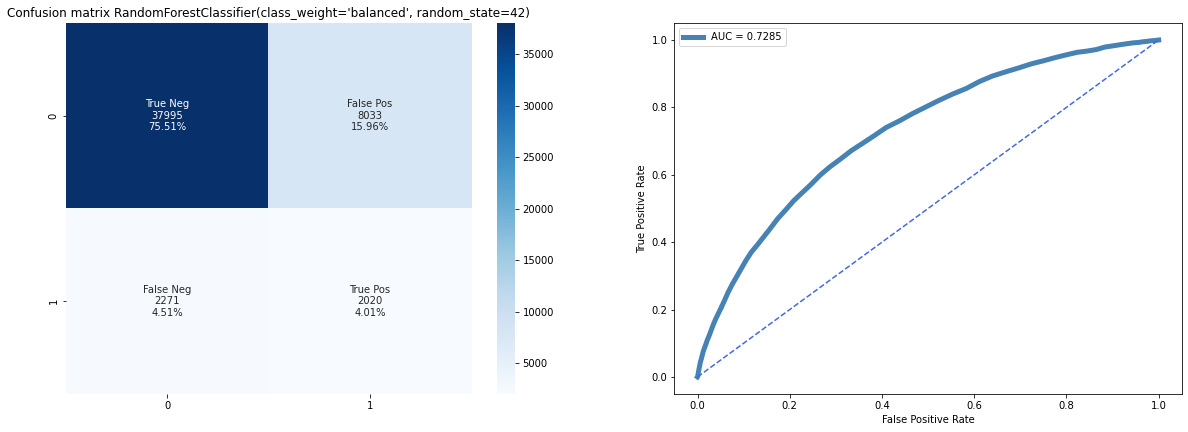

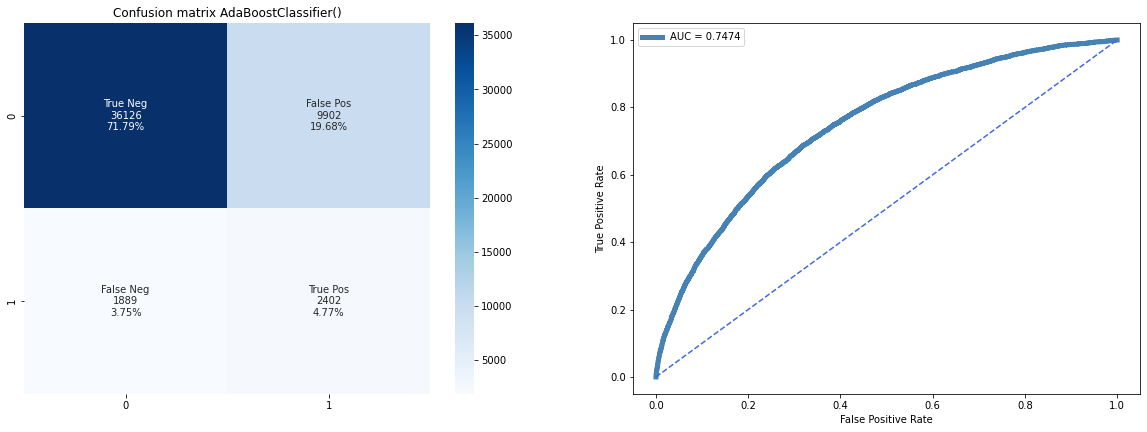

In [110]:
df_model_over = pd.DataFrame(columns=['model', 'run_time', 'Score test', 'Score train', 'accuracy', 'precision', 'recall', 'f1_score', 'roc auc score', 'fpr', 'tpr','fbeta'])

for key in classifiers:

    start_time = time.time()
    classifier_over = classifiers[key]
    model_over = classifier_over.fit(X_train_under_sm, y_train_under_sm)

    y_pred_over = model_over.predict(X_test) 
    y_pred_proba_over = model_over.predict_proba(X_test)[:,1]
    
    fig = plt.figure(figsize=(20,15))
    
    plt.subplot(221)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred_over)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cnf_matrix.flatten()/np.sum(cnf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cnf_matrix, annot=labels, fmt="", cmap='Blues')
    
    plt.title(f'Confusion matrix {classifier_over}')
    

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_test, y_pred_proba_over)
    plt.plot(fpr, tpr, color='steelblue', linewidth=5, label='AUC = %0.4f' %roc_auc_score(y_test, y_pred_proba_over))
    plt.plot([0, 1], [0, 1], color='royalblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.show()
            
    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'Score test': model_over.score(X_test,y_test),
           'Score train': model_over.score(X_train_under_sm,y_train_under_sm),
           'accuracy': accuracy_score(y_test, y_pred_over),
           'precision': precision_score(y_test, y_pred_over, average='binary'),
           'recall': recall_score(y_test, y_pred_over, average='binary'),
           'f1_score': f1_score(y_test, y_pred_over, average='binary'),
           'roc auc score': roc_auc_score(y_test, y_pred_proba_over),
           'fpr':fpr,
           'tpr':tpr,
           'fbeta': fbeta_score(y_test,model_over.predict(X_test),beta=10)
    }
    
    df_model_over = df_model_over.append(row, ignore_index=True)

In [111]:
df_model_over

,model,run_time,Score test,Score train,accuracy,precision,recall,f1_score,roc auc score,fpr,tpr,fbeta
0,LogisticRegression,0.27,0.765874,0.704888,0.765874,0.198130,0.572827,0.294424,0.750998,"[0.0, 2.172590597027896e-05, 4.345181194055792...","[0.0, 0.0, 0.0, 0.00046609182008855747, 0.0004...",0.562298
1,LGBMClassifier,0.18,0.771875,0.819856,0.771875,0.208042,0.596831,0.308536,0.767460,"[0.0, 0.0, 0.0, 2.172590597027896e-05, 2.17259...","[0.0, 0.00023304591004427873, 0.00046609182008...",0.585988
2,XGBClassifier,0.78,0.752479,0.921511,0.752479,0.189535,0.580750,0.285796,0.746687,"[0.0, 2.172590597027896e-05, 2.172590597027896...","[0.0, 0.0, 0.0006991377301328362, 0.0006991377...",0.569120
3,KNeighborsClassifier,1.07,0.660645,0.742577,0.660645,0.118745,0.463994,0.189097,0.598794,"[0.0, 0.018314938732945162, 0.1098461805857304...","[0.0, 0.0438126310883244, 0.20135166627825682,...",0.451011
4,RandomForestClassifier,0.41,0.795226,1.000000,0.795226,0.200935,0.470753,0.281651,0.728458,"[0.0, 2.172590597027896e-05, 8.690362388111584...","[0.0, 0.0, 0.0, 0.00023304591004427873, 0.0004...",0.464576
5,AdaBoostClassifier,0.62,0.765675,0.705407,0.765675,0.195221,0.559776,0.289485,0.747432,"[0.0, 0.0, 0.0, 4.345181194055792e-05, 4.34518...","[0.0, 0.00023304591004427873, 0.00046609182008...",0.549614


### Score ROC AUC

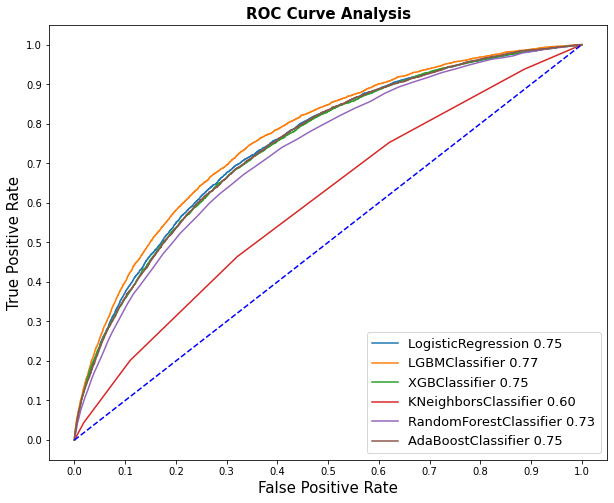

In [112]:
fig = plt.figure(figsize=(10,8))

for i in df_model_over.index:
    plt.plot(df_model_over.loc[i]['fpr'], 
             df_model_over.loc[i]['tpr'], 
             label=df_model_over.loc[i]['model']+ f" {df_model_over.loc[i]['roc auc score']:.2f}"
             )
    
plt.plot([0,1], [0,1], color='blue', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

## Best models

### Optimization

Optimisation du modèle d'un point de vue métier (fonction coût métier)

On cherche à optimiser le modèle, donc trouver les meilleurs paramètres avec lesquels le modèle est le plus performant. 

#### Fonction coût métier

La fonction coût est une estimation du gain financier ou de perte financière pour l’entreprise. Il s’agit d’une problématique métier et l’objectif est de minimiser :

- Le nombre de clients ayant des situations sans risque de défaut de paiement dont les demandes de crédits sont refusées par erreur (l’erreur de type I ou les faux positifs) ;
- Le nombre de crédits accordés par erreur aux clients ayant des risques élevés de défaut de paiement (l’erreur de type II ou les faux négatifs).

Pour atteindre cet objectif, il faut :

- Maximiser le rappel et la précision ;
- Minimiser le taux de faux positifs (FPR) et le taux de faux négatifs (FNR).

On va définir une fonction métier adaptée au projet qui permet d'attribuer plus de poids à la minimisation des FN.

Et on va effectuer une nouvelle recherche des hyper-paramètres via HyperOpt se basant sur la fonction métier proposée, de cette façon, ils seront choisis de sorte à minimiser la perte pour l'entreprise. 

La bibliothèque hyperopt a un but similaire à gridsearch, mais au lieu de faire une recherche exhaustive de l’espace de paramètre, il évalue quelques points de données bien choisis, puis extrapole la solution optimale basée sur la modélisation. En pratique, cela signifie qu’il faut souvent beaucoup moins d’itérations pour trouver une bonne solution.



In [113]:
poids = 10 #importance de fn par rapport à fp

def custom_score(y_true, y_pred) :
    
    '''fonction qui pénalise le faux positive (fp) et le faux négatif (fn)'''
    
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()
    
    fscore = poids*fn +fp
    
    return fscore

## LGBMClassifier

In [114]:
from sklearn.model_selection import cross_val_predict
#Parameter space
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type',['gbdt','dart','goss']),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1), #alias "subsample"
    'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
    'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
    'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
    'verbose': -1,
    'subsample': None, #overridden by bagging_fraction
    'reg_alpha': None, #overridden by lambda_l1
    'reg_lambda': None, #overridden by lambda_l2
    'min_sum_hessian_in_leaf': None, #overrides min_child_weight
    'min_child_samples': None, #overridden by min_data_in_leaf
    'colsample_bytree': None, #overridden by feature_fraction
    'min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum_hessian
}


def objective(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'class_weight':params['class_weight'],
        'boosting_type':params['boosting_type'],
        'num_leaves': int(params['num_leaves']),
        'learning_rate': params['learning_rate'],
        'subsample_for_bin': int(params['subsample_for_bin']),
        'feature_fraction': params['feature_fraction'],
        'bagging_fraction': params['feature_fraction'],
        'min_data_in_leaf': int(params['min_data_in_leaf'])
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    y_pred = cross_val_predict(model, X_train_over_sm, y_train_over_sm, method='predict', cv=cv)
    score = custom_score(y_train_over_sm, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [115]:
best = fmin(fn=objective, space=space, max_evals=10, algo=tpe.suggest)

100%|██████████| 10/10 [37:26<00:00, 224.61s/trial, best loss: -823834.0]


In [116]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'bagging_fraction': 0.9354953794273403, 'boosting_type': 1, 'class_weight': 1, 'feature_fraction': 0.93024312875431, 'lambda_l1': 0, 'lambda_l2': 1, 'lambda_l2_positive': 0.0012127982318298192, 'learning_rate': 0.18505249030026003, 'min_child_weight': 10.32070386760009, 'min_data_in_leaf': 25.0, 'num_leaves': 99.0, 'subsample_for_bin': 240000.0}


In [117]:
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    num_leaves= int(best['num_leaves']),
    learning_rate= best['learning_rate'],
    subsample_for_bin= int(best['subsample_for_bin']),
    feature_fraction= best['feature_fraction'],
    bagging_fraction= best['feature_fraction'],
    min_data_in_leaf= int(best['min_data_in_leaf']),)

lgbm.fit(X_train_over_sm, y_train_over_sm)

LGBMClassifier(bagging_fraction=0.93024312875431,
               feature_fraction=0.93024312875431,
               learning_rate=0.18505249030026003, min_data_in_leaf=25,
               num_leaves=99, subsample_for_bin=240000)

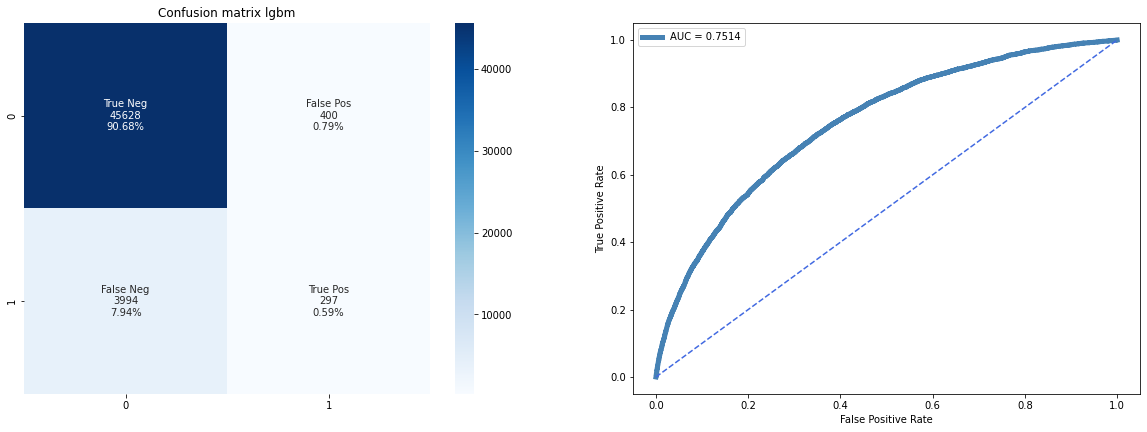

In [118]:
y_pred_over = lgbm.predict(X_test) 
y_pred_proba_over = lgbm.predict_proba(X_test)[:,1]
    
fig = plt.figure(figsize=(20,15))
    
plt.subplot(221)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_over)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cnf_matrix.flatten()/np.sum(cnf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt="", cmap='Blues')

plt.title(f'Confusion matrix lgbm')


plt.subplot(222)
fpr,tpr,_ = roc_curve(y_test, y_pred_proba_over)
plt.plot(fpr, tpr, color='steelblue', linewidth=5, label='AUC = %0.4f' %roc_auc_score(y_test, y_pred_proba_over))
plt.plot([0, 1], [0, 1], color='royalblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [119]:
lgbm.score(X_test,y_test)

predictions = lgbm.predict(X_test)
  
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     46028
         1.0       0.43      0.07      0.12      4291

    accuracy                           0.91     50319
   macro avg       0.67      0.53      0.54     50319
weighted avg       0.88      0.91      0.88     50319



# Feature Importance


Librairie SHAP pour calculer la feature importance globale afin de connaitre d'une manière générale les principales features qui contribuent à l'élaboration du modèle.

features importance des prédictions faites par le modèle sur xtest

In [120]:
import shap

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_importance)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


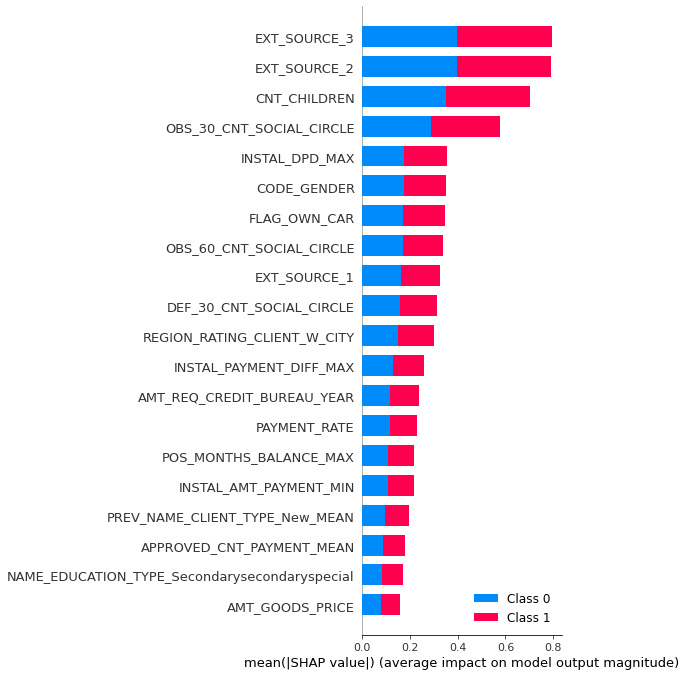

In [121]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

100%|===================| 117346/117411 [25:38<00:00]        

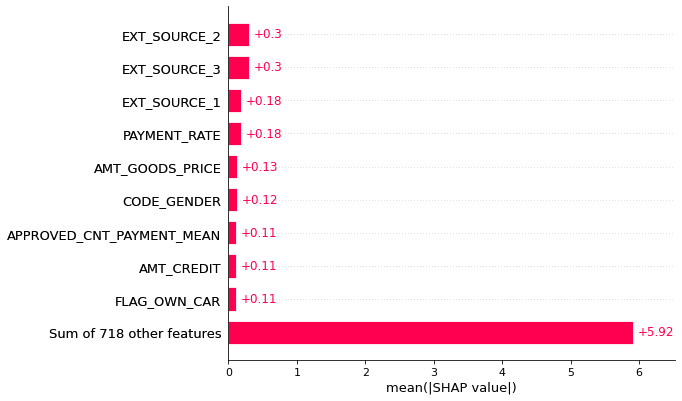

In [122]:
# compute SHAP values
explainer = shap.Explainer(lgbm, X_train)
shap_values = explainer(X_train, check_additivity=False)
shap.plots.bar(shap_values)

In [123]:
import pickle

pickle.dump(lgbm, open("LGBMClassifier.pkl", "wb"))


In [124]:
#X_train_over_sm.to_csv("train.csv")
#X_test.to_csv("test.csv")
#y.to_csv('TARGET.csv')

Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec les 208 best features identifiées. Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [125]:
sample_export = X_train.reset_index()

In [126]:
# échantillon pour l'API
sample_export = sample_export.sample(frac=0.35, random_state=8)

# save datas to csv
sample_export.to_csv('sample_preproc.csv')

In [127]:
customer_sample = application_train[application_train.SK_ID_CURR.isin(sample_export.SK_ID_CURR.values.tolist())]

In [128]:
customer_sample = customer_sample[["SK_ID_CURR","NAME_FAMILY_STATUS","NAME_EDUCATION_TYPE","NAME_INCOME_TYPE","NAME_CONTRACT_TYPE","CODE_GENDER","AMT_INCOME_TOTAL","OCCUPATION_TYPE","DAYS_BIRTH","DAYS_EMPLOYED"]]

In [129]:
customer_sample = customer_sample.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+ ', '', x))

In [130]:
# save to csv
customer_sample.to_csv('customer_sample.csv')

In [131]:
# %%flake8

# create an explainer with model and datas preprocessed
explainer = shap.Explainer(lgbm, X_train)

In [132]:
pickle.dump(explainer, open('explainer.pkl', 'wb'))

In [133]:
# export shap_values
shap_values_export = explainer(sample_export, check_additivity=False)

pickle.dump(shap_values_export, open('shap_values.pkl', 'wb'))


100%|===================| 41064/41094 [06:04<00:00]        

## Conclusion

LightGbm ressort comme étant le plus rapide, le plus performant sur la métrique classique de l'AUC

In [134]:
customerid = 141754

In [135]:
def load_prediction(sample, customerid, clf):
    X=sample.iloc[:, :-1]
    score = clf.predict_proba(X[X.SK_ID_CURR == int(customerid)])[:,1]
    return score

prediction = load_prediction(sample_export, customerid, lgbm)

In [136]:
prediction

array([0.72480959])

In [230]:
pickle.dump(sample_export, open('sample_export.pkl', 'wb'))

In [232]:
sample

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,ORGANIZATION_TYPE_Industrytype13,ORGANIZATION_TYPE_Industrytype2,ORGANIZATION_TYPE_Industrytype3,ORGANIZATION_TYPE_Industrytype4,ORGANIZATION_TYPE_Industrytype5,ORGANIZATION_TYPE_Industrytype6,ORGANIZATION_TYPE_Industrytype7,ORGANIZATION_TYPE_Industrytype8,ORGANIZATION_TYPE_Industrytype9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_LegalServices,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Se